In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation
from scipy import ndimage
import os

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import math
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
import torch
import torch.nn.functional as F
from time import time
from IPython.display import Image, HTML, clear_output

In [ ]:
import imageio
import os
import moviepy.editor as mvp
from pathlib import Path
from tqdm.notebook import tqdm

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3211264/45929032 bytes (7.0%)7307264/45929032 bytes (15.9%)11460608/45929032 bytes (25.0%)15310848/45929032 bytes (33.3%)19251200/45929032 bytes (41.9%)23150592/45929032 bytes (50.4%)27148288/45929032 bytes (59.1%)31178752/45929032 bytes (67.9%)35135488/45929032 bytes (76.5%)38985728/45929032 bytes (84.9%)42852352/45929032 bytes (93.3%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
%load_ext autoreload
%autoreload 2

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## get lungs and cluster lesions

Fill me in please! Don't forget code examples:

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'
# load ct, normalize, rotate, 
ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
# find the two lungs
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
# masks
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask #lungs without lesions
target_mask2 = ~bkgd # lungs with lesions
target_mask3 = ct_mask_small.astype(bool) #lesions only
SLICE=100
# get largest lesion using label
lab, nr_ = label(target_mask3)
lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
# get dimensions of one_big_lesion and find one_big_lesion is in left or right lung 
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
for i in [1,2]:
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
# pad each dimension to length multiple of 32 (needed for inpainting, maye not anymore)
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])

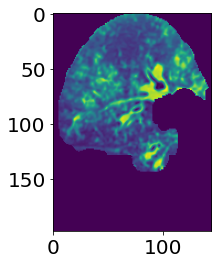

In [ ]:
plt.imshow(im)

## cluster lesions


In [ ]:
SEED_VALUE = .19
numSegments = 300
segments = slic(im, n_segments = numSegments, sigma = .2, multichannel=False, compactness=.1)
background, lesion_area, vessels = superpixels(im, segments, vessel_threshold=.5)
lesion_area_merged1 = merge_labeled_clusters(lesion_area, DIST=20)
lesion_area_merged1 = merge_labeled_clusters(lesion_area_merged1, DIST=30)
lesion_area_merged = merge_labeled_clusters(lesion_area_merged1, DIST=40)
tgt_minis, tgt_minis_coords, tgt_minis_masks, tgt_minis_big, tgt_minis_coords_big, tgt_minis_masks_big = select_lesions_match_conditions(lesion_area_merged, target_img_covid, skip_index=0)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_minis, tgt_minis_coords, tgt_minis_masks, seed_value=SEED_VALUE, seed_method='max')

21

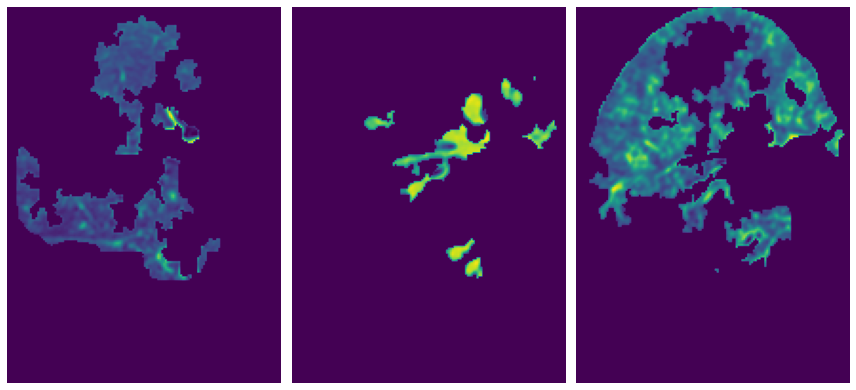

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow((background>0)*im)
ax[1].imshow((vessels>0)*im)
ax[2].imshow((lesion_area>0)*im)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()
len(targets)

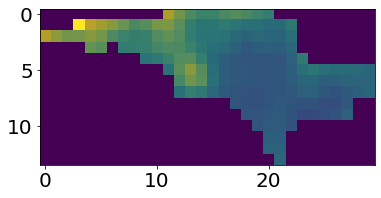

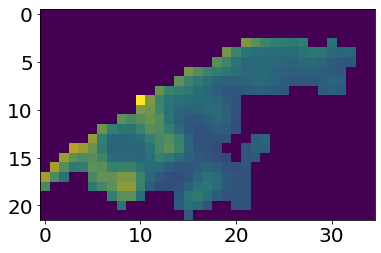

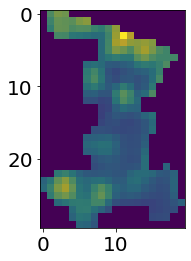

In [ ]:
for idx, (i,j) in enumerate(zip(targets,seeds)):
  if idx == 3: break
  plt.figure()
  plt.imshow(i[...,0])
  plt.imshow(j, alpha=.3)

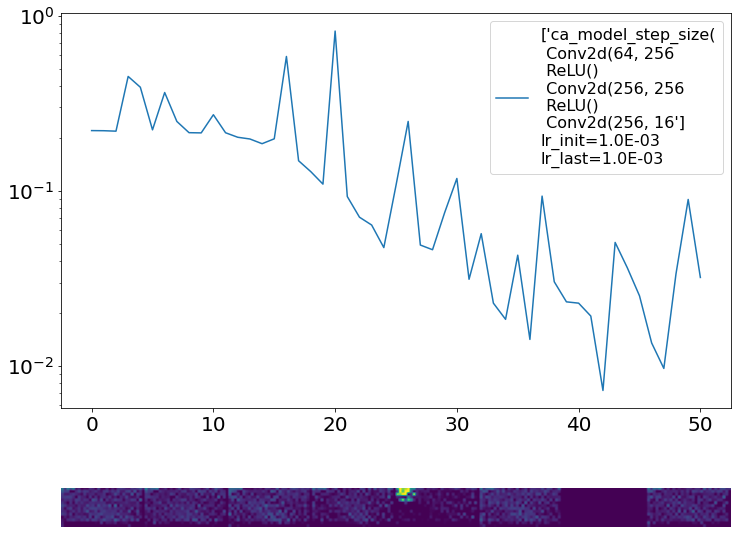

50 0.03209617733955383


KeyboardInterrupt: ignored

In [ ]:
# main cellular automata training loop
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
GROW_ON_K_ITER = 1
BACKGROUND_INTENSITY = 0.11 # .01 #0.19
STEP_SIZE = 1 #.1 .3
SCALE_MASK = .19 # .1 #0.19
path_parent = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/p07_cellsclamp_fixed_DELETE'
path_save_synthesis = f'{path_parent}_grow={GROW_ON_K_ITER}_bg={BACKGROUND_INTENSITY:.02f}_step={STEP_SIZE}_scale_mask={SCALE_MASK}_seed_value={SEED_VALUE}/'
Path(path_save_synthesis).mkdir(parents=True, exist_ok=True)

for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion<=14:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_step_size(device = device, grow_on_k_iter=GROW_ON_K_ITER, background_intensity=BACKGROUND_INTENSITY, step_size=STEP_SIZE, scale_mask=SCALE_MASK)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0).to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = inner_iter,
        seed = seed_batch,
        current_epoch = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())
    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #save model
  torch.save(model.model.state_dict(), f'{path_save_synthesis}weights_{idx_lesion}.pt')

  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  # path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient05_superpix_sigma=.2_compact=.1/'
  
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

## experiments

In [ ]:
# main cellular automata training loop
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
GROW_ON_K_ITER = 1
BACKGROUND_INTENSITY = 0.01 # .11 #0.19
STEP_SIZE = .1 #.3
SCALE_MASK = 1 # .1 #0.19
path_parent = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/p08_laplacian_regularizer'
path_save_synthesis = f'{path_parent}_grow={GROW_ON_K_ITER}_bg={BACKGROUND_INTENSITY:.02f}_step={STEP_SIZE}_scale_mask={SCALE_MASK}_seed_value={SEED_VALUE}/'
Path(path_save_synthesis).mkdir(parents=True, exist_ok=True)

for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion<4:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_laplacian_regularizer(device = device, grow_on_k_iter=GROW_ON_K_ITER, background_intensity=BACKGROUND_INTENSITY, step_size=STEP_SIZE, scale_mask=SCALE_MASK)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        seed = seed_batch,
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        epochs_inside = inner_iter,
        epoch_outside = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())

    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      break
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)
      fig, ax = plt.subplots(2,1, figsize=(12,6))
      # stack_alive_mask.append(stack_figure_for_plot(alive_mask, 1))
      # stack_mask_diff.append(stack_figure_for_plot(mask_diff, 1))
      ax[0].imshow(stack_figure_for_plot(alive_mask, 1))
      ax[1].imshow(stack_figure_for_plot(mask_diff, 1))


  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #save model
  torch.save(model.model.state_dict(), f'{path_save_synthesis}weights_{idx_lesion}.pt')

  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  # path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient05_superpix_sigma=.2_compact=.1/'
  
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

  break

(0) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(1) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(2) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(3) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(4) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(5) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(6) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(7) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(8) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(9) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(10) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(11) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(12) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 1, 14, 30])
(13) y=torch.Size([8, 64, 14, 30]) alive_mask=torch.Size([8, 

## temp

(2122, 8, 1, 14, 30)


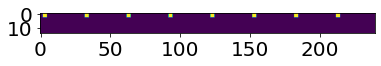

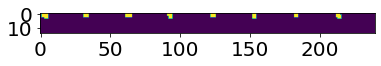

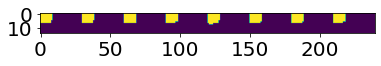

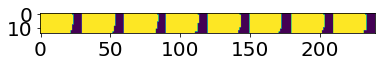

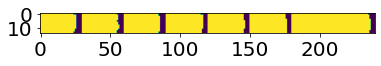

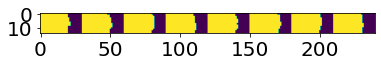

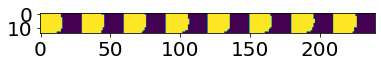

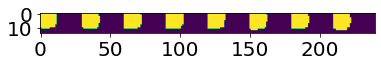

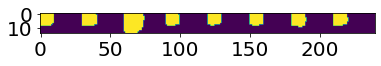

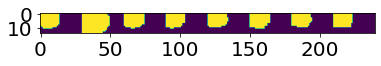

In [ ]:
print(np.shape(alive_masks))
for i in np.linspace(0,10,10):
  i = int(i)
  a = stack_figure_for_plot(alive_masks[i])
  plt.figure()
  plt.imshow(a)

(2122, 8, 16, 14, 30)
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]
[0.01 0.1 ]


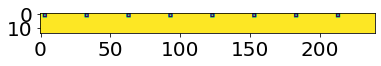

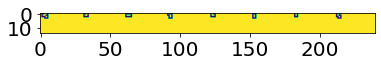

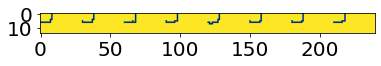

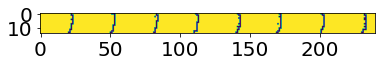

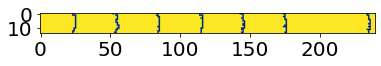

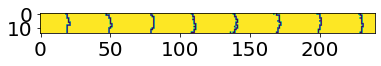

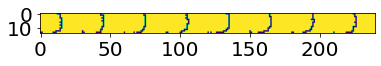

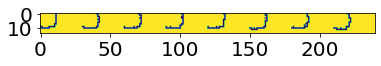

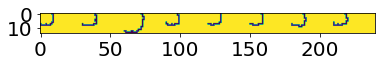

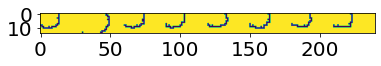

In [ ]:
print(np.shape(mask_diffs))
for i in np.linspace(0,10,10):
  i = int(i)
  a = stack_figure_for_plot(mask_diffs[i])
  print(np.unique(a))
  plt.figure()
  plt.imshow(a)

In [ ]:
np.save('images/alive_masks.npy', alive_masks)
np.save('images/mask_diffs.npy', mask_diffs)
np.save('images/outs.npy', outs)

In [ ]:
alive_masks = np.load('images/alive_masks.npy')
mask_diffs = np.load('images/mask_diffs.npy')
outs = np.load('images/outs.npy')

In [ ]:
np.shape(outs)

(256, 14, 30, 1)

(256, 14, 30, 1)


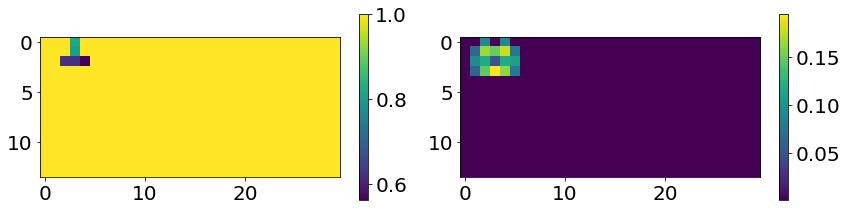

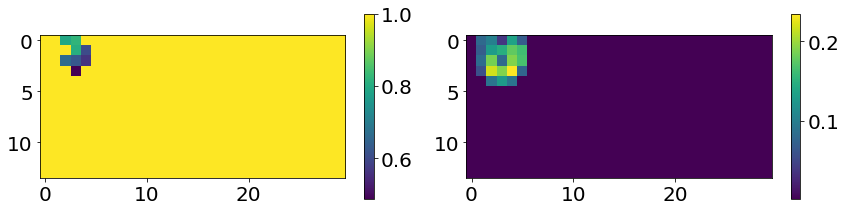

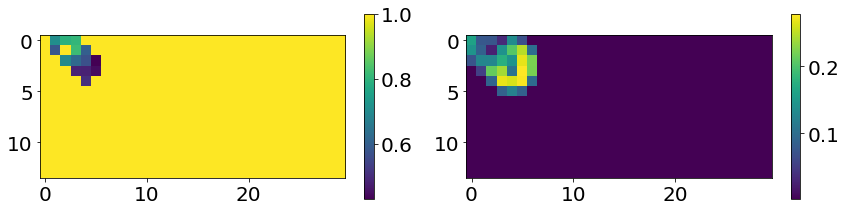

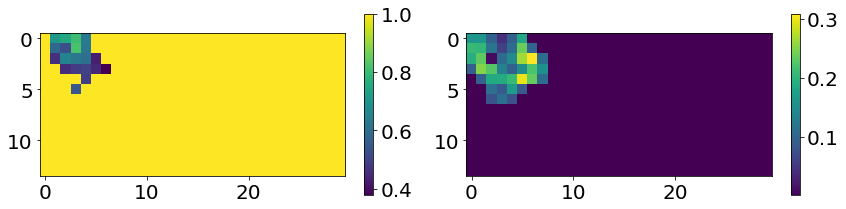

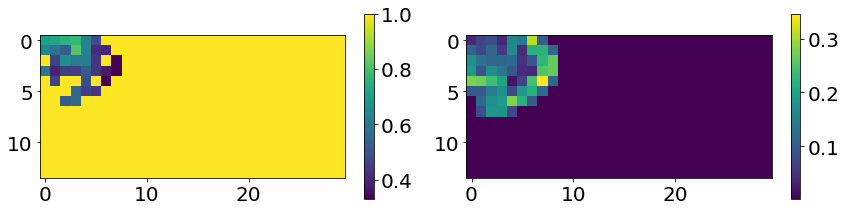

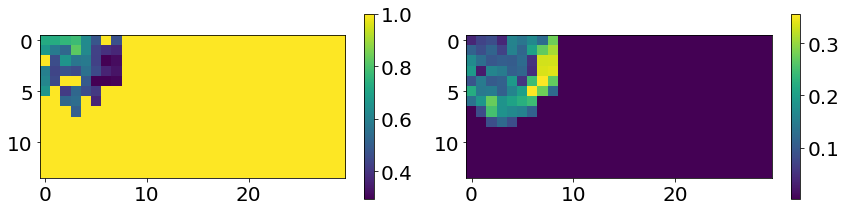

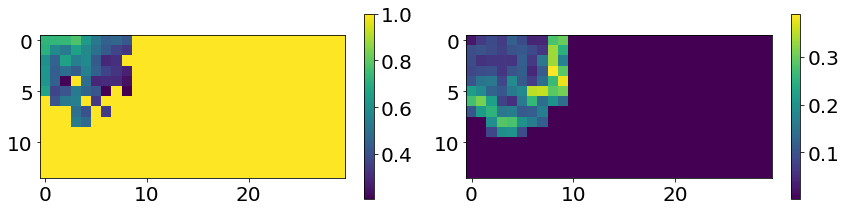

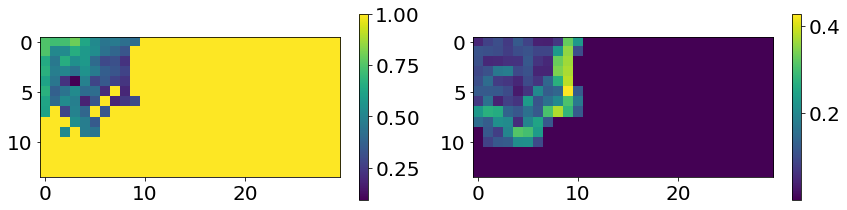

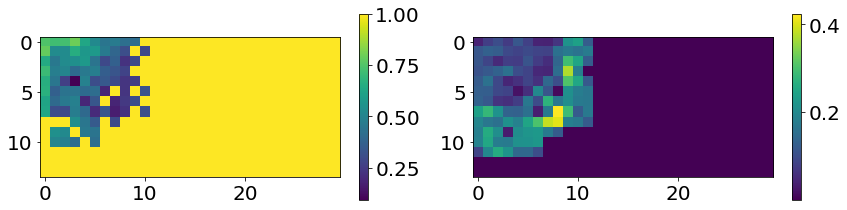

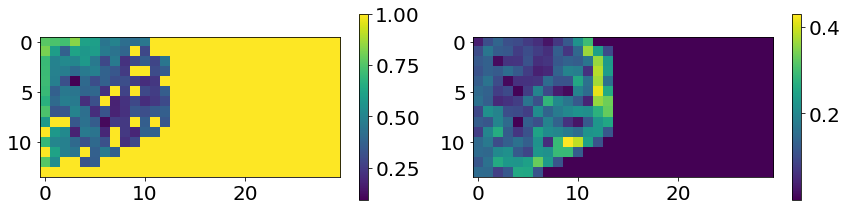

In [ ]:
print(np.shape(outs))
for i in np.linspace(0,10,10):
  i = int(i)
  a = np.squeeze(outs[i])
  b = np.squeeze(a2g[i].numpy())
  fig, ax = plt.subplots(1,2, figsize=(12,3))
  im0 = ax[0].imshow(a)
  im1 = ax[1].imshow(b)
  fig.colorbar(im0, ax=ax[0])
  fig.colorbar(im1, ax=ax[1])
  fig.tight_layout()

In [ ]:
print(np.shape(outs))
outs2 = np.moveaxis(outs,-1,1)
print(np.shape(outs2))
B, _, H, W = np.shape(outs2)
print(B, _, H, W)
outs3 = np.reshape(outs2, (B, 1, 1, H, W))
print(np.shape(outs3))

(256, 14, 30, 1)
(256, 1, 14, 30)
256 1 14 30
(256, 1, 1, 14, 30)


In [ ]:
a2 = torch.tensor(outs)
a2 = torch.moveaxis(a2, -1,1)
print(a2.shape)
a2g = gradient_filter(a2)
a2g.shape

torch.Size([256, 1, 14, 30])


torch.Size([256, 1, 14, 30])

In [ ]:
!pip install -q kornia

     |████████████████████████████████| 276kB 8.1MB/s 


In [ ]:
import kornia
gradient_filter = kornia.filters.sobel

## calc_laplacian_regularizer_loss

In [ ]:
def calc_laplacian_regularizer_loss(self, weights, lattice_sizes, l1=0.0, l2=0.0):
  '''https://discuss.pytorch.org/t/implmentations-of-the-laplacian-regularization-loss/83346'''
    # weight:  B C H W
    if not l1 and not l2:
        return 0.0
    B, _, H, W = weights.shape

    weights = weights.view(B, lattice_sizes[0], lattice_sizes[1], H, W)

    diff1 = weights[:, 1:, :, :, :] - weights[:, :-1, :, :, :]
    diff2 = weights[:, :, 1:, :, :] - weights[:, :, :-1, :, :]
    if l1:
        resutl1 = torch.abs(diff1).sum()
        resutl1 += torch.abs(diff2).sum()
    if l2:
        resutl2 = torch.pow(diff1, 2).sum()
        resutl2 += torch.pow(diff2, 2).sum()

    if l1 and not l2:
        return resutl1
    elif not l1 and l2:
        return resutl2
    else:
        return resutl1 + resutl2

In [ ]:
def stack_figure_for_plot(batch_array, channels=1):
  '''stack the visible channels of a batch of images into a horizontal mosaic'''
  stack=[]
  for array in batch_array:
    array = np.moveaxis(array,0,-1)
    array = np.squeeze(array[...,:channels])
    if channels==1:
      array = np.squeeze(array)
    stack.append(array)
  stack = np.hstack(np.squeeze(stack))
  return stack

In [ ]:
import torch.nn as nn

In [ ]:
class ca_model_laplacian_regularizer(nn.Module):
    def __init__(self, checkpoint = None, seq_layers = None, device = 'cuda', grow_on_k_iter=3, background_intensity=.19, step_size=1, scale_mask=1):
        '''
        Kind of a modular class for a CA model
        args:
            checkpoint = 'path/to/model.pt'
            seq_layers = nn.Sequential(your, pytorch, layers)
            device = 'cuda' or 'cpu'
        '''
        super(ca_model_laplacian_regularizer, self).__init__()

        self.ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]).to(device)
        self.sobel_x = (torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])/8.0).to(device)
        self.lap = (torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])/16.0).to(device)
        self.grow_on_k_iter = grow_on_k_iter
        self.background_intensity = background_intensity
        self.step_size = step_size
        self.scale_mask = scale_mask
        
        if seq_layers is not None:
            self.model = seq_layers
        else:
            self.model = nn.Sequential(
                nn.Conv2d(64, 256, kernel_size = 3,padding =1,  bias = True),  
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size = 3,padding =1,  bias = True),  
                nn.ReLU(),
                nn.Conv2d(256, 16, kernel_size =  1, bias = True),
            )
            
        '''
        initial condition for "do nothing" behaviour:
            * all biases should be zero
            * the weights of the last layer should be zero
        '''
        for l in range(len(self.model)):
            if isinstance(self.model[l], nn.Conv2d):
                self.model[l].bias.data.fill_(0)
                if l == len(self.model) -1:
                    self.model[l].weight.data.fill_(0)

        if checkpoint is not None:
            self.load_state_dict(torch.load(checkpoint))

        self.to(device= device)
    
    def perchannel_conv(self, x, filters):
        '''filters: [filter_n, h, w]'''
        b, ch, h, w = x.shape
        y = x.reshape(b*ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters[:,None])
        return y.reshape(b, -1, h, w)

    def perception(self, x):
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap])
        return self.perchannel_conv(x, filters)
        
    def normalize_grads(self):
        '''
        gradient normalization for constant step size and to avoid spikes 
        '''
        for p in self.parameters():
            p.grad.data = p.grad.data/(p.grad.data.norm()+1e-8)    
            
            
    def get_alive_mask(self, x):
        '''
        looks for cells that have values over 0.1, 
        and allows only their adjacent cells to participate in growth
        '''
        alpha = x[:,1:2,:,:]
        pooled = (F.max_pool2d(alpha, 3,1, padding =1 ) > 0.1).float()
        return pooled
    
    def train_step(self, seed, target, target_loss_func, epochs_inside, epoch_outside = 1000, masked_loss=False):
        '''
        a single training step for the model,
        feel free to play around with different loss functions like L1 loss 

        the loss is calculated for only the first 4 channels of the output
        '''
        x = seed 
        for epoch_in in range(epochs_inside):
            x, alive_mask, other_mask =  self.forward(x, epoch_in, epoch_outside)

        # print(x[:,:4, :,:].shape, target.shape)
        # batch_mean_rmse_per_pixel = torch.mean(torch.sqrt((x[:,:1, :,:] - target)**2),dim=0)
        batch_mean_rmse_per_pixel = torch.mean(torch.sqrt((x[:,0, :,:] - target[:,0,:,:])**2),dim=0)

        if masked_loss == True:
            alive_mask_dilated = (F.max_pool2d(alive_mask[0], 3,1, padding =1 ) > 0.1).float()
            # alive_mask_dilated = torch.from_numpy(binary_closing(alive_mask[0].cpu().numpy() > 0.1)).float().to('cuda')
            target_loss  =  target_loss_func(x[:,:1, :,:] * alive_mask_dilated, target * alive_mask_dilated)  
        else:
            target_loss  =  target_loss_func(x[:,:2, :,:] * target[:,1:,...], target * target[:,1:,...]) # used to synthesize almost all nodules 



        loss = target_loss 
            
        return loss, x, alive_mask.cpu().numpy(), other_mask.cpu().numpy() #batch_mean_rmse_per_pixel.detach().cpu().numpy()

    def forward(self, x, epoch_in, epoch_outside):
        '''
        nice little forward function for the model
        1. fetches an alive mask 
        2. generates another random mask of 0's and 1's 
        3. updates the input 
        4. applies alive mask 
        '''
        mask_previous = alive_mask = (x[:,1:2,:,:] > 0.1).float()
        if epoch_outside < 100: 
          alive_mask = self.get_alive_mask(x)
        else:
          if epoch_in % self.grow_on_k_iter == 0:
            alive_mask = self.get_alive_mask(x)
          else:
            alive_mask = (x[:,1:2,:,:] > 0.1).float()
        
        mask_diff = alive_mask - mask_previous
        mask_new_cells_clamped = torch.clip((1-mask_diff) + self.background_intensity,0,self.step_size) #make sure this is only applied to the first channel
        
        mask_new_cells_clamped_ones = torch.ones_like(torch.squeeze(mask_new_cells_clamped))*self.scale_mask
        mask_new_cells_clamped2 = torch.repeat_interleave(mask_new_cells_clamped,16,1)
        for idx_channel in np.arange(1,16,1):
          mask_new_cells_clamped2[:,idx_channel,:,:] = mask_new_cells_clamped_ones
        
        mask = torch.clamp(torch.round(torch.rand_like(x[:,:1,:,:])) , 0,1) # original mask used
        y = self.perception(x)
        print(f'({epoch_in}) y={y.shape} alive_mask={alive_mask.shape}')
        out = x + self.model(y)*mask*mask_new_cells_clamped2
        out *= alive_mask
        
        return out, alive_mask, mask_new_cells_clamped2

## cellular automata ONE EXAMPLE

In [ ]:
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
IDX=0
target, coord, mask, this_seed = targets[IDX], coords[IDX], masks[IDX], seeds[IDX]
GROW_ON_K_ITER = 3
BACKGROUND_INTENSITY = 0.19
STEP_SIZE = 1
path_parent = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06'
path_results = f'{path_parent}_grow={GROW_ON_K_ITER}_bg={BACKGROUND_INTENSITY:.02f}_step={STEP_SIZE}/'
Path(path_results).mkdir(parents=True, exist_ok=True)

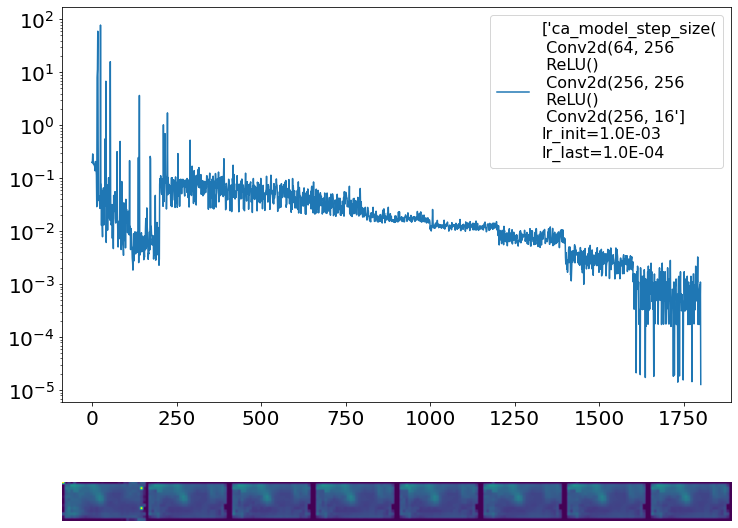

1800 1.2903443348477595e-05
5.6 mins
(256, 14, 30)


NameError: ignored

In [ ]:
# prepare seed
height, width, _ = np.shape(target)
seed = np.zeros([1, height, width, num_channels], np.float32)
for i in range(num_channels-1):
  seed[:,..., i+1] = this_seed
# initialize model
model = ca_model_step_size(device = device, grow_on_k_iter=GROW_ON_K_ITER, background_intensity=BACKGROUND_INTENSITY, step_size=STEP_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
model_str = correct_label_in_plot(model)
# Preparing the seed pool
target0 = target
pool_size = 1024
seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
losses = []
# train automata
target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
start = time()
alive_masks = []
mask_diffs = []
inner_iter2 = 0
for i in range(epochs):
  ##
  if i < 100:
    inner_iter = 100
  elif i % 200 == 0: 
    inner_iter2 = inner_iter2 + 10
    inner_iter = np.min([inner_iter2, 100])

  scheduler.step()
  batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
  seed_batch = seed_pool[batch_idx].to(device)
  seed_batch[:1] = seed_tensor.to(device)
  
  loss, out, alive_mask, mask_diff = model.train_step(
      target = target_batch, 
      target_loss_func = F.mse_loss, 
      iters = inner_iter,
      seed = seed_batch,
      current_epoch = i,
      masked_loss = False
      )
  
  mask_diffs.append(mask_diff)
  alive_masks.append(alive_mask)

  seed_pool[batch_idx] = out.detach().to(device)
  loss.backward() # calculate gradients
  model.normalize_grads() # normalize them
  optimizer.step() # update weights and biases 
  optimizer.zero_grad() # prevent accumulation of gradients
  losses.append(loss.item())
  #early-stopping
  if loss.item() < 1e-5: break

  if i % 50==0 or i  == epochs-1:
    model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

stop = time()
time_total = f'{(stop-start)/60:.1f} mins'
print(time_total)
model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure

#lesion synthesis
x = torch.tensor(seed).permute(0,-1,1,2).to(device)
outs = []
with torch.no_grad():
  for i,special_sequence in zip(range(256),[1,1,1,3]*64):
    # x = model(x,special_sequence,101)
    x, alive_mask_, mask_diff_ = model(x,i,101)
    # x = model(x,i,i)
    out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
    outs.append(out)

#save results    
outs_masked = []
for out_ in outs:
    out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
    out_masked[out_masked==1]=0
    outs_masked.append(out_masked)
outs_int = np.asarray(outs_masked)
print(np.shape(outs_int))
outs_int = np.clip(outs_int, 0 ,1)
outs_int = (outs_int*255).astype('int16')

## extra

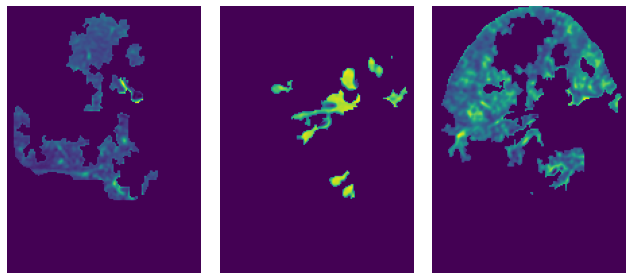

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9,4))
ax[0].imshow((background>0)*im)
ax[1].imshow((vessels>0)*im)
ax[2].imshow((lesion_area>0)*im)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

0.3254901960784314

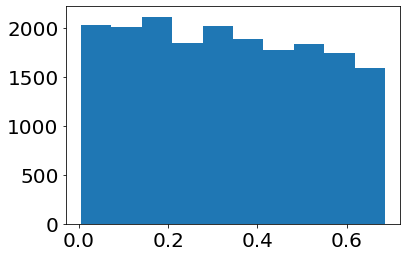

In [ ]:
plt.hist(background[background>0]/255);
# plt.xlim([0,1])
np.median(background[background>0]/255)

array([0.   , 0.534, 0.721, 0.552, 0.504, 0.615])

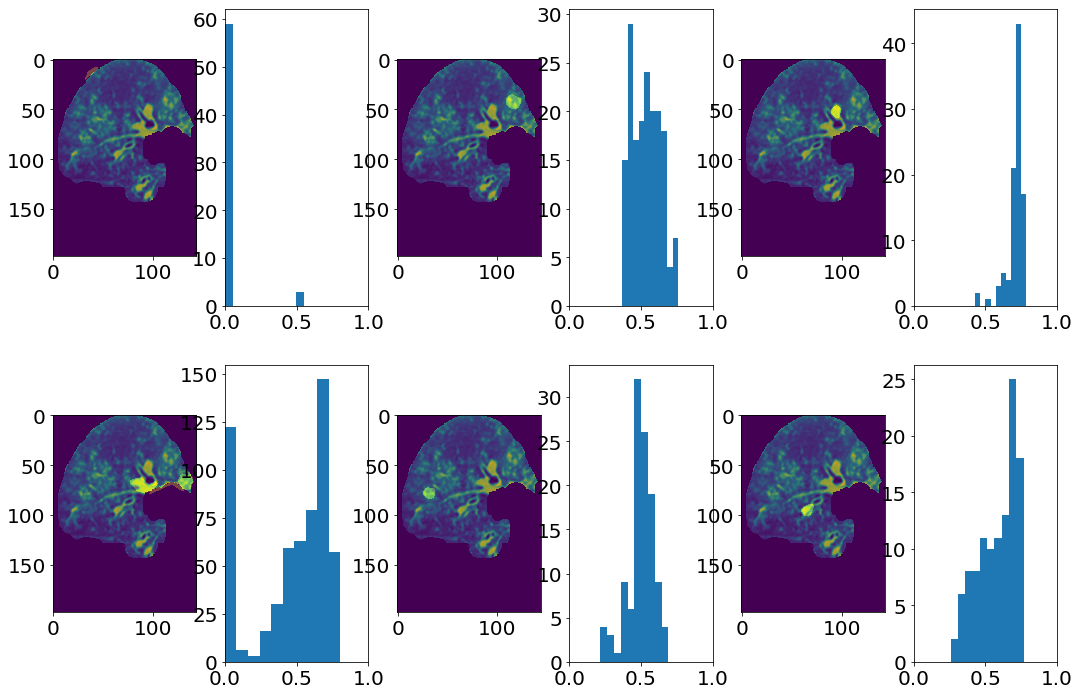

In [ ]:
labeled, nr = label(vessels)
labels = [1,2,3,4,5,6]
medians = []
fig, ax = plt.subplots(2,(len(labels)), figsize=(18,12))
for idx, i in enumerate(labels):
  ax.flat[idx*2].imshow(im)
  ax.flat[idx*2].imshow(labeled==i, alpha=.3)
  ax.flat[idx*2+1].hist((im*(labeled==i))[(labeled==i)>0]);
  ax.flat[idx*2+1].set_xlim([0,1])
  medians.append(np.median((im*(labeled==i))[(labeled==i)>0]))
medians = [float(f'{i:.03f}') for i in medians]
np.asarray(medians)

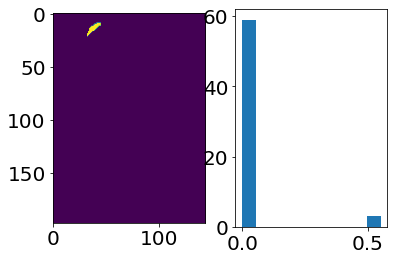

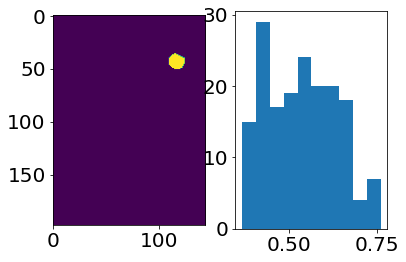

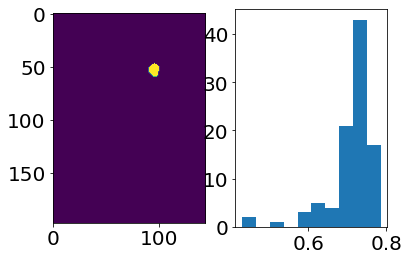

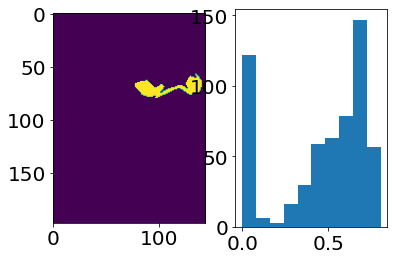

In [ ]:
labeled, nr = label(vessels)
for i in [1,2,3,4]:
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(labeled==i)
  ax[1].hist((im*(labeled==i))[(labeled==i)>0]);

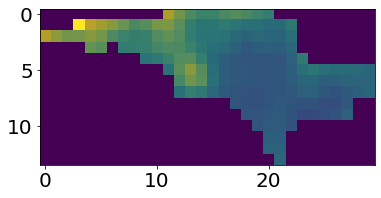

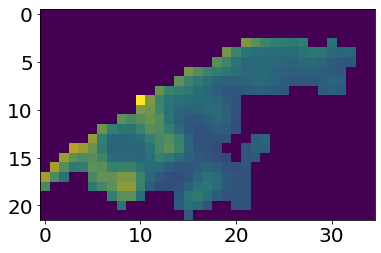

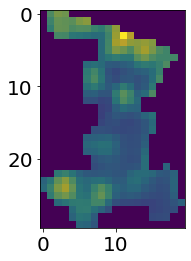

In [ ]:
for idx, (i,j) in enumerate(zip(targets,seeds)):
  if idx == 3: break
  plt.figure()
  plt.imshow(i[...,0])
  plt.imshow(j, alpha=.3)

## continue

In [ ]:
# main cellular automata training loop
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
GROW_ON_K_ITER = 1
BACKGROUND_INTENSITY = 0.01 # .11 #0.19
STEP_SIZE = .1 #.3
SCALE_MASK = 1 # .1 #0.19
path_parent = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/p06_'
path_save_synthesis = f'{path_parent}_grow={GROW_ON_K_ITER}_bg={BACKGROUND_INTENSITY:.02f}_step={STEP_SIZE}_scale_mask={SCALE_MASK}_seed_value={SEED_VALUE}/'
Path(path_save_synthesis).mkdir(parents=True, exist_ok=True)

for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion<4:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_step_size(device = device, grow_on_k_iter=GROW_ON_K_ITER, background_intensity=BACKGROUND_INTENSITY, step_size=STEP_SIZE, scale_mask=SCALE_MASK)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = inner_iter,
        seed = seed_batch,
        current_epoch = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())
    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #save model
  torch.save(model.model.state_dict(), f'{path_save_synthesis}weights_{idx_lesion}.pt')

  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  # path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient05_superpix_sigma=.2_compact=.1/'
  
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

  break

In [ ]:
# main cellular automata training loop
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
GROW_ON_K_ITER = 1
BACKGROUND_INTENSITY = 0.01 # .11 #0.19
STEP_SIZE = .1 #.3
SCALE_MASK = 1 # .1 #0.19
path_parent = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/p07_laplacian_regularizer'
path_save_synthesis = f'{path_parent}_grow={GROW_ON_K_ITER}_bg={BACKGROUND_INTENSITY:.02f}_step={STEP_SIZE}_scale_mask={SCALE_MASK}_seed_value={SEED_VALUE}/'
Path(path_save_synthesis).mkdir(parents=True, exist_ok=True)

for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion<4:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_laplacian_regularizer(device = device, grow_on_k_iter=GROW_ON_K_ITER, background_intensity=BACKGROUND_INTENSITY, step_size=STEP_SIZE, scale_mask=SCALE_MASK)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = inner_iter,
        seed = seed_batch,
        current_epoch = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())
    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)
      fig, ax = plt.subplots(2,1, figsize=(12,6))
      stack_alive_mask.append(stack_figure_for_plot(alive_mask, 1))
      stack_mask_diff.append(stack_figure_for_plot(mask_diff, 1))
      ax[0].imshow(stack_figure_for_plot(alive_mask, 1))
      ax[1].imshow(stack_figure_for_plot(mask_diff, 1))


  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #save model
  torch.save(model.model.state_dict(), f'{path_save_synthesis}weights_{idx_lesion}.pt')

  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  # path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient05_superpix_sigma=.2_compact=.1/'
  
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

  break

In [ ]:
torch.save(model.model.state_dict(), f'{path_results}weights.pt')



In [ ]:
np.shape(mask_diffs), 
fig, ax = plt.subplots(2,1)
ax[0].imshow(alive_masks[0][0,0,...])
ax[1].imshow(mask_diffs[0][0,0,...])

In [ ]:
for i in range(10):
  m_alive, m_diff = alive_masks[i], mask_diffs[i]
  fig, ax = plt.subplots(2,1)
  ax[0].imshow(m_alive[0,0,...])
  ax[1].imshow(m_diff[0,0,...])
  for axx in ax.ravel(): axx.axis('off')

In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *

In [ ]:
1

ca_model_perception_clamp(
  (model): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
idx_lesion

NameError: ignored

In [ ]:
for i in np.arange(1,16,1):
  print(i)

NameError: ignored

In [ ]:
#@title clustering one slice {vertical-output: true}
# segment with intensity thresholding
im = copy(target_img_covid[...,SLICE])
im_r = im.reshape(im.shape[0]*im.shape[1])
for i in range(im_r.shape[0]):
    im_r[i] = np.floor(im_r[i]*5)
im2 = im_r.reshape(im.shape[0],im.shape[1])

# clustering
mask_lesion2 = im2==2
mask_lesion1 = im2==1
mask_lesion = mask_lesion1 + mask_lesion2
small_lesions, labels  = apply_dbscan_to_mask(mask_lesion, skip_low_intensity=2)
# select_lesions_match_conditions and make or add to the targets and seeds lists
tgt_small, tgt_coords_small, tgt_masks_small, tgt_big, tgt_coords_big, tgt_masks_big =  select_lesions_match_conditions(small_lesions, target_img_covid, max_size=1000)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_small, tgt_coords_small, tgt_masks_small)
print(f'lesions = {len(tgt_small)}, big lesions = {len(tgt_big)}')
# select lesions and add to lists from smaller lesions
smaller_merged_all = []
for idx_, (mask_small, coords_big_) in enumerate(zip(tgt_masks_big, tgt_coords_big)):
  # if idx_ >=1:break
  # grid search DBSCAN
  eps_sel, samp_sel = grid_search_DBSCAN_params(mask_small)
  smaller_lesions, labels = apply_dbscan_to_mask(mask_small, eps=eps_sel, min_samples=samp_sel)
  # use label to get not clustered areas 
  skip_low_intensity = 2
  last_idx = np.max(np.unique(labels))+skip_low_intensity
  smaller_multi = label_mask_and_add_to_clusters(smaller_lesions, last_idx)
  # merge labeled clusters
  smaller_merged = merge_labeled_clusters(smaller_multi, DIST=40)
  smaller_merged_orig_size = np.zeros_like(im)
  smaller_merged_orig_size[coords_big_[0]:coords_big_[1],coords_big_[2]:coords_big_[3]] = smaller_merged
  # select_lesions_match_conditions
  tgt_small2, tgt_coords_small2, tgt_masks_small2, tgt_big2, tgt_coords_big2, tgt_masks_big2 =  select_lesions_match_conditions(smaller_merged_orig_size, target_img_covid, max_size=1000)
  # make or add to the lists of targets and seeds
  targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_small2, tgt_coords_small2, tgt_masks_small2, init_lists=False, targets=targets, seeds=seeds, masks=masks, coords=coords)
  print(f'total lesions = {len(targets)}')
  smaller_merged_all.append(smaller_merged)

lesions = 7, big lesions = 2



total lesions = 10



total lesions = 16
